In [1]:
library('magrittr')
library('tibble')
library('dplyr')
library('tidyr')
library('ggplot2')
library('RColorBrewer')
library('readr')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



In [2]:
il2_data <- 
    read_tsv(
        "data.tsv",
        col_types=cols(
            `Sample:`=col_character(),
            `Week`=col_factor(levels=c('Week 1', 'Week 2', 'Week 3', 'Week 4')),
            `Donor`=col_factor(levels=c('Donor 42', 'Donor 43')),
            `Condition`=col_factor(levels=c('no IL2', '200 IU/mL IL2')),
            .default=col_double()
        )
    )

il2_data %>% head

Sample:,Week,Donor,Condition,Count,Live | Freq. of Parent,Live/CCR7+ CD45RO+ | Freq. of Parent,Live/CCR7+ CD45RO- | Freq. of Parent,Live/CCR7- CD45RO+ | Freq. of Parent,Live/CCR7- CD45RO- | Freq. of Parent,Live/CD4+ CD8+ | Freq. of Parent,Live/CD4+ CD8- | Freq. of Parent,Live/CD4- CD8+ | Freq. of Parent,Live/CD4- CD8- | Freq. of Parent
1.fcs,Week 4,Donor 42,no IL2,1150000,21.9,36.5,17.7,42.5,3.31,1.95,85.6,10.8,1.58
2.fcs,Week 4,Donor 42,no IL2,1090000,22.1,39.7,16.3,40.2,3.83,1.97,85.6,10.7,1.75
3.fcs,Week 4,Donor 42,no IL2,983000,20.8,38.5,13.6,44.0,3.89,1.82,85.5,11.0,1.60
4.fcs,Week 4,Donor 42,200 IU/mL IL2,1650000,75.2,20.3,18.2,44.2,17.30,5.50,49.7,41.0,3.79
5.fcs,Week 4,Donor 42,200 IU/mL IL2,1600000,76.1,19.3,18.5,44.6,17.60,4.83,50.1,41.3,3.82
6.fcs,Week 4,Donor 42,200 IU/mL IL2,1690000,75.8,19.2,18.3,44.3,18.20,4.92,50.0,41.3,3.83


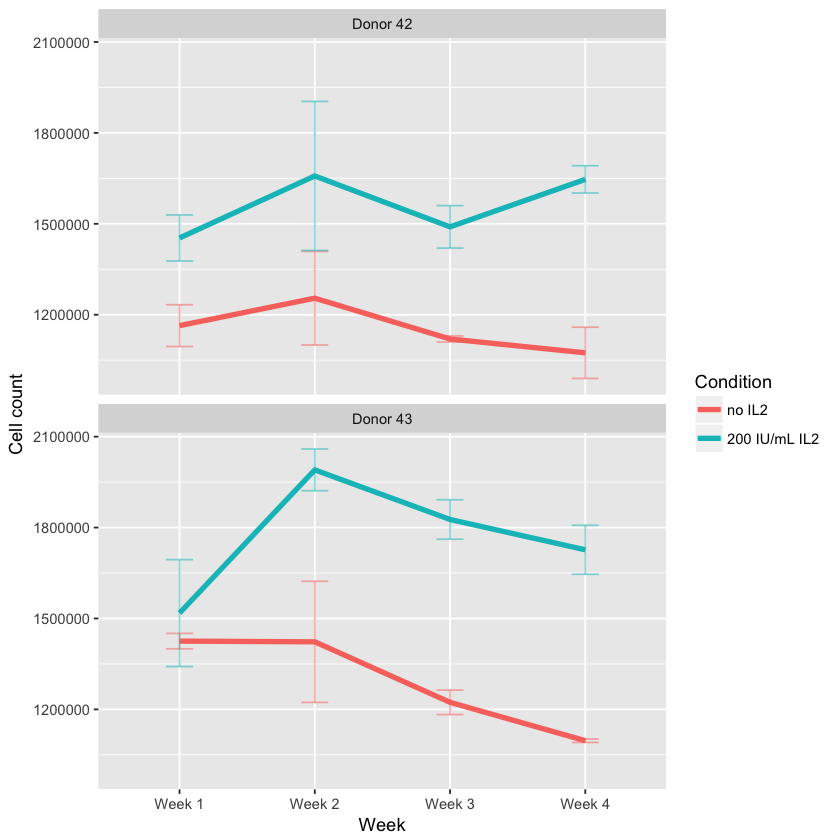

In [3]:
il2_data %>%
    group_by(`Week`, `Donor`, `Condition`) %>%
    summarize(
        `Avg_count`=mean(`Count`),
        `Sd_count`=sd(`Count`)
    ) %>%
    ggplot(aes(x=`Week`, y=`Avg_count`, color=`Condition`)) +
    geom_line(aes(group=`Condition`), size=1.5) +
    geom_errorbar(
        aes(
            ymin=`Avg_count`-`Sd_count`,
            ymax=`Avg_count`+`Sd_count`
        ),
        width=.2,
        alpha=.5
    ) +
    facet_wrap(~`Donor`, nrow=2) +
    ylab('Cell count')

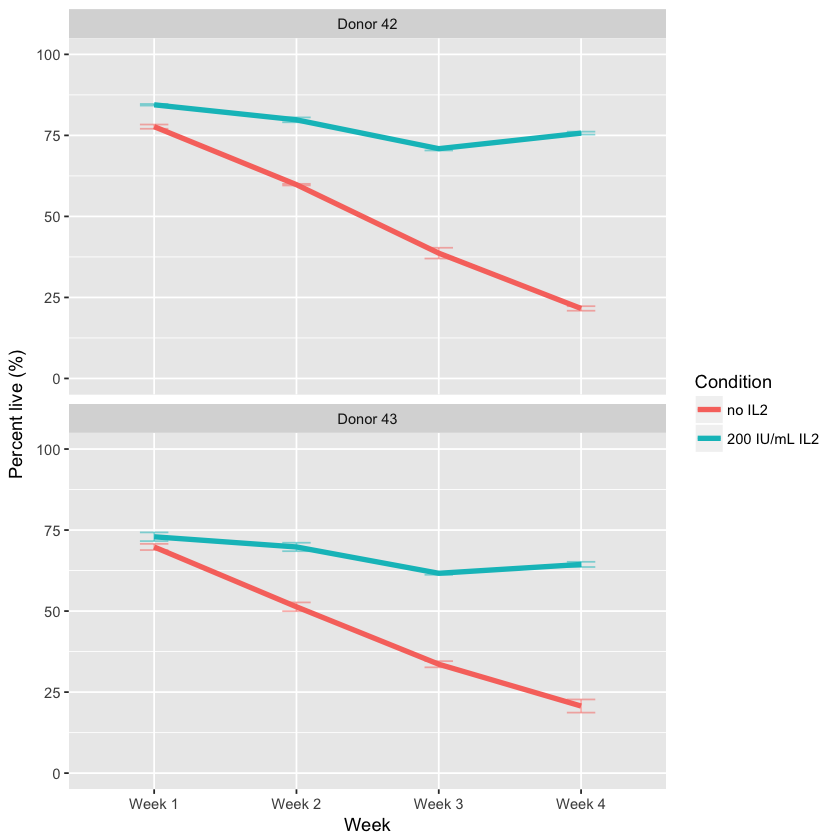

In [4]:
il2_data %>%
    group_by(`Week`, `Donor`, `Condition`) %>%
    summarize(
        `Avg_flive`=mean(`Live | Freq. of Parent`),
        `Sd_flive`=sd(`Live | Freq. of Parent`)
    ) %>%
    ggplot(aes(x=`Week`, y=`Avg_flive`, color=`Condition`)) +
    geom_line(aes(group=`Condition`), size=1.5) +
    geom_errorbar(
        aes(
            ymin=`Avg_flive`-`Sd_flive`,
            ymax=`Avg_flive`+`Sd_flive`
        ),
        width=.2,
        alpha=.5
    ) +
    facet_wrap(~`Donor`, nrow=2) +
    ylab('Percent live (%)') +
    ylim(0, 100)

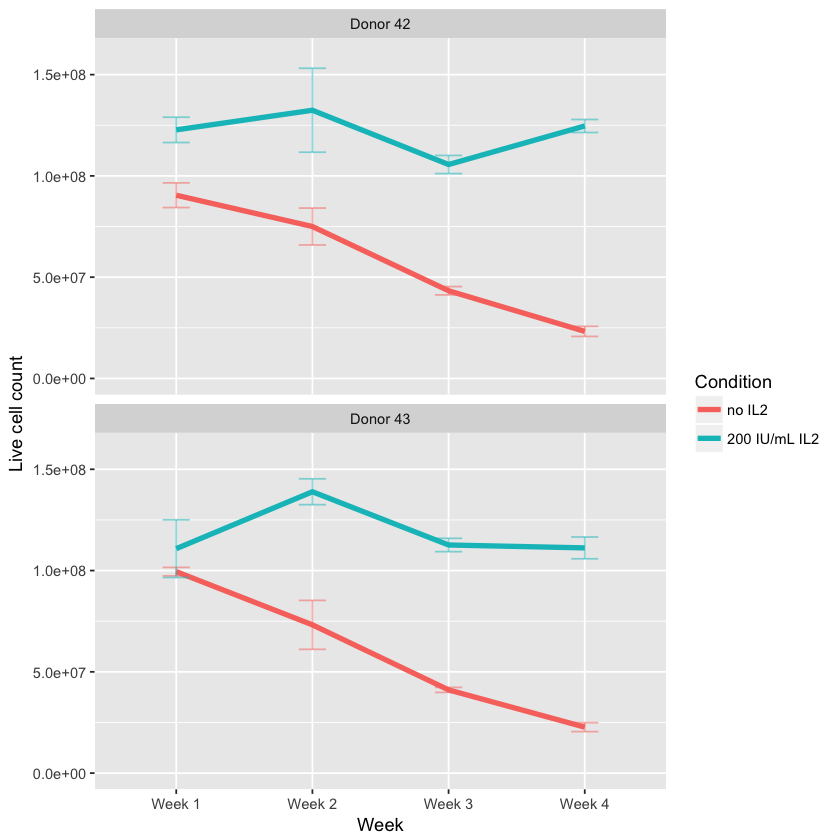

In [15]:
il2_data %>%
    mutate(`Live count`=`Count` * `Live | Freq. of Parent`) %>%
    group_by(`Week`, `Donor`, `Condition`) %>%
    summarize(
        `Avg_lcount`=mean(`Live count`),
        `Sd_lcount`=sd(`Live count`)
    ) %>%
    ggplot(aes(x=`Week`, y=`Avg_lcount`, color=`Condition`)) +
    geom_line(aes(group=`Condition`), size=1.5) +
    geom_errorbar(
        aes(
            ymin=`Avg_lcount`-`Sd_lcount`,
            ymax=`Avg_lcount`+`Sd_lcount`
        ),
        width=.2,
        alpha=.5
    ) +
    facet_wrap(~`Donor`, nrow=2) +
    ylab('Live cell count') +
    ylim(0, 1.6e8)

In [12]:
naive_data <-
    il2_data %>%
    select(
        `Week`:`Live | Freq. of Parent`,
        `Naive`=`Live/CCR7+ CD45RO- | Freq. of Parent`,
        `CM`=`Live/CCR7+ CD45RO+ | Freq. of Parent`,
        `EM`=`Live/CCR7- CD45RO+ | Freq. of Parent`,
        `EMRA`=`Live/CCR7- CD45RO- | Freq. of Parent`
    ) %>%
    gather(
        key='Population',
        value='Population Frequency',
        factor_key=TRUE,
        `Naive`:`EMRA`
    ) %>%
    mutate(
        `Population count`=`Count` * `Population Frequency` * `Live | Freq. of Parent`
    ) %>%
    group_by(`Week`, `Donor`, `Condition`, `Population`) %>%
    summarize(
        `Avg_freq`=mean(`Population Frequency`),
        `Sd_freq`=sd(`Population Frequency`),
        `Avg_pcount`=mean(`Population count`),
        `Sd_pcount`=sd(`Population count`)
    )

naive_data %>% head

Week,Donor,Condition,Population,Avg_freq,Sd_freq,Avg_pcount,Sd_pcount
Week 1,Donor 42,no IL2,Naive,41.26667,0.3055050,3732930860,240543329
Week 1,Donor 42,no IL2,CM,31.96667,0.5033223,2890040890,149998347
Week 1,Donor 42,no IL2,EM,13.46667,0.3511885,1219746380,113510707
Week 1,Donor 42,no IL2,EMRA,13.26667,0.4041452,1201353910,110250859
Week 1,Donor 42,200 IU/mL IL2,Naive,34.90000,0.6082763,4280981617,157567808
Week 1,Donor 42,200 IU/mL IL2,CM,28.00000,0.3464102,3435083200,137806192


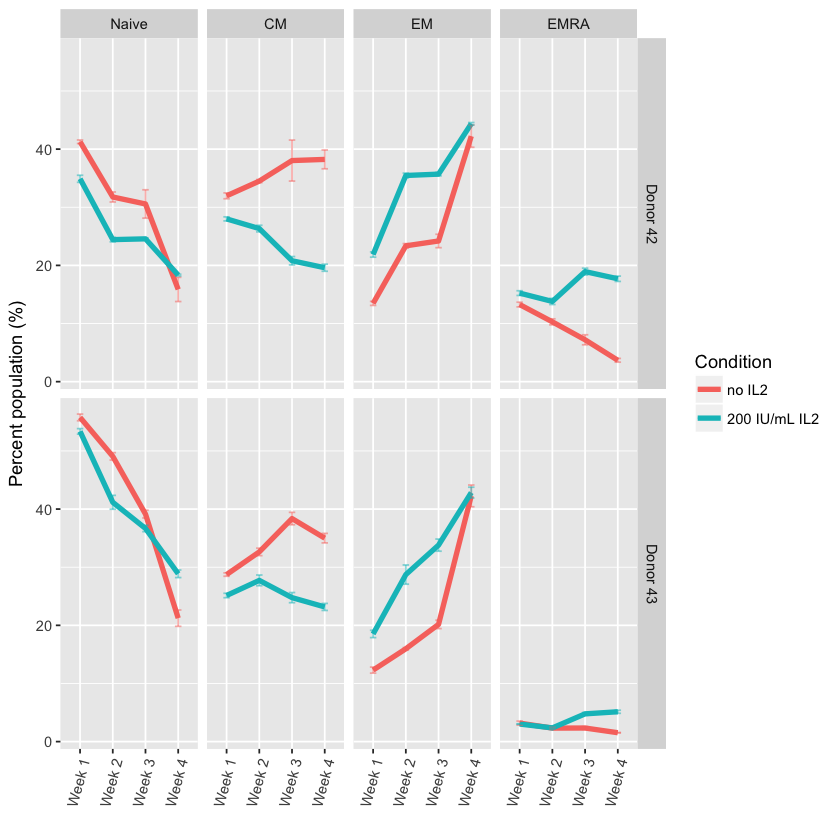

In [13]:
naive_data %>%
    ggplot(aes(x=`Week`, y=`Avg_freq`, color=`Condition`)) +
        geom_line(aes(group=`Condition`), size=1.5) +
        geom_errorbar(
            aes(
                ymin=`Avg_freq`-`Sd_freq`,
                ymax=`Avg_freq`+`Sd_freq`
            ),
            width=.2,
            alpha=.5
        ) +
        facet_grid(`Donor`~`Population`) +
        theme(axis.text.x=element_text(angle=75, hjust=1)) +
        xlab("") +
        ylab("Percent population (%)")


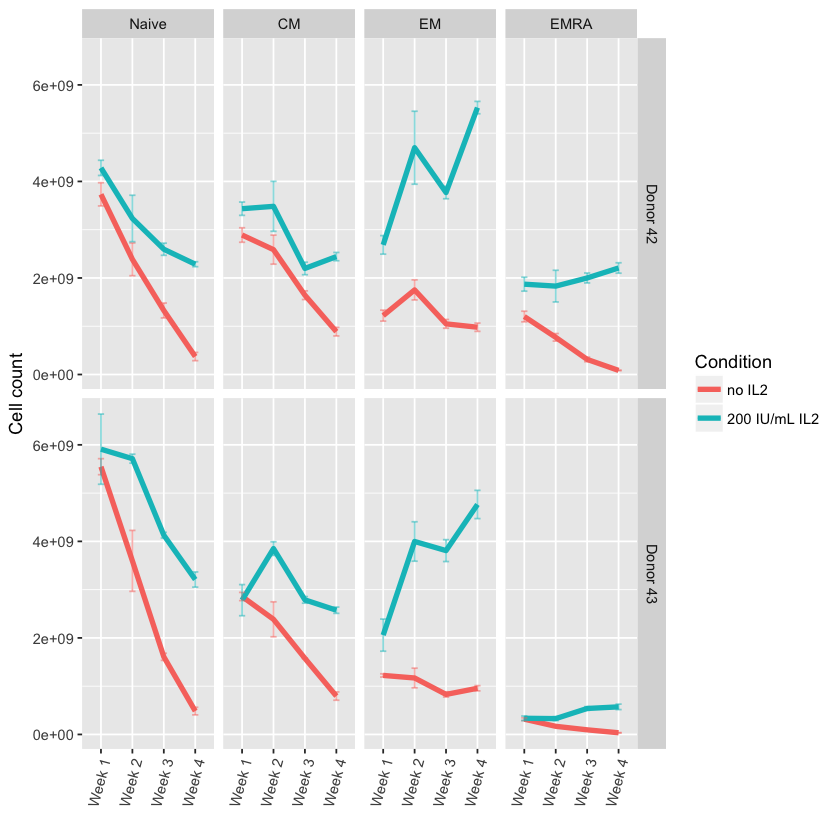

In [14]:
naive_data %>%
    ggplot(aes(x=`Week`, y=`Avg_pcount`, color=`Condition`)) +
        geom_line(aes(group=`Condition`), size=1.5) +
        geom_errorbar(
            aes(
                ymin=`Avg_pcount`-`Sd_pcount`,
                ymax=`Avg_pcount`+`Sd_pcount`
            ),
            width=.2,
            alpha=.5
        ) +
        facet_grid(`Donor`~`Population`) +
        theme(axis.text.x=element_text(angle=75, hjust=1)) +
        xlab("") +
        ylab("Cell count")

In [9]:
cd48_data <-
    il2_data %>%
    select(
        `Week`:`Live | Freq. of Parent`,
        `CD4+ CD8-`=`Live/CD4+ CD8- | Freq. of Parent`,
        `CD4+ CD8+`=`Live/CD4+ CD8+ | Freq. of Parent`,
        `CD4- CD8+`=`Live/CD4- CD8+ | Freq. of Parent`,
        `CD4- CD8-`=`Live/CD4- CD8- | Freq. of Parent`
    ) %>%
    gather(
        key='Population',
        value='Population Frequency',
        factor_key=TRUE,
        `CD4+ CD8-`:`CD4- CD8-`
    ) %>%
    mutate(
        `Population count`=`Count` * `Population Frequency` * `Live | Freq. of Parent`
    ) %>%
    group_by(`Week`, `Donor`, `Condition`, `Population`) %>%
    summarize(
        `Avg_freq`=mean(`Population Frequency`),
        `Sd_freq`=sd(`Population Frequency`),
        `Avg_pcount`=mean(`Population count`),
        `Sd_pcount`=sd(`Population count`)
    )

cd48_data %>% head

Week,Donor,Condition,Population,Avg_freq,Sd_freq,Avg_pcount,Sd_pcount
Week 1,Donor 42,no IL2,CD4+ CD8-,71.5666667,0.05773503,6474704160,436331673
Week 1,Donor 42,no IL2,CD4+ CD8+,3.0600000,0.07810250,277090106,24427875
Week 1,Donor 42,no IL2,CD4- CD8+,24.5000000,0.00000000,2216532150,149158486
Week 1,Donor 42,no IL2,CD4- CD8-,0.8766667,0.04932883,79124322,1962160
Week 1,Donor 42,200 IU/mL IL2,CD4+ CD8-,61.3000000,0.10000000,7523632580,395980871
Week 1,Donor 42,200 IU/mL IL2,CD4+ CD8+,4.5000000,0.23579652,552894541,50769310


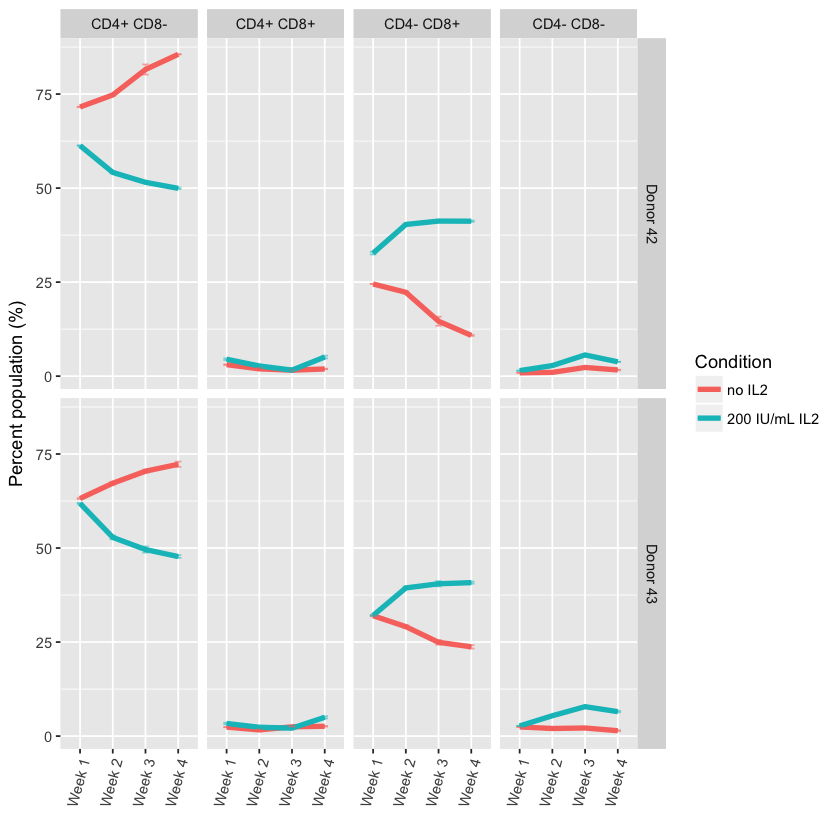

In [10]:
cd48_data %>%
    ggplot(aes(x=`Week`, y=`Avg_freq`, color=`Condition`)) +
        geom_line(aes(group=`Condition`), size=1.5) +
        geom_errorbar(
            aes(
                ymin=`Avg_freq`-`Sd_freq`,
                ymax=`Avg_freq`+`Sd_freq`
            ),
            width=.2,
            alpha=.5
        ) +
        facet_grid(`Donor`~`Population`) +
        theme(axis.text.x=element_text(angle=75, hjust=1)) +
        xlab("") +
        ylab("Percent population (%)")


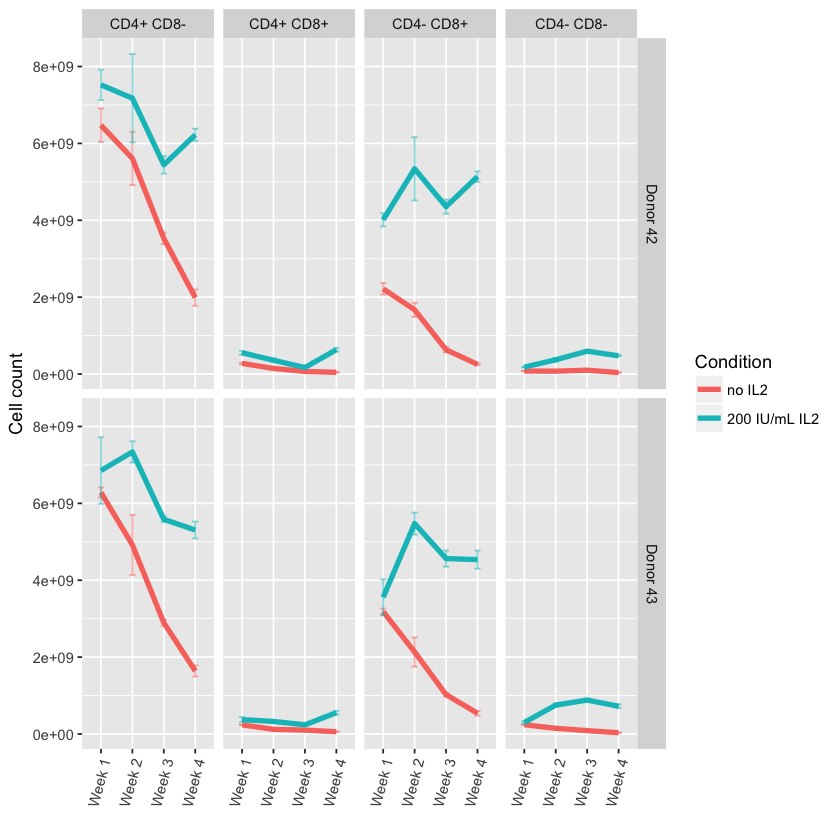

In [11]:
cd48_data %>%
    ggplot(aes(x=`Week`, y=`Avg_pcount`, color=`Condition`)) +
        geom_line(aes(group=`Condition`), size=1.5) +
        geom_errorbar(
            aes(
                ymin=`Avg_pcount`-`Sd_pcount`,
                ymax=`Avg_pcount`+`Sd_pcount`
            ),
            width=.2,
            alpha=.5
        ) +
        facet_grid(`Donor`~`Population`) +
        theme(axis.text.x=element_text(angle=75, hjust=1)) +
        xlab("") +
        ylab("Cell count")